# Set up parameters, PyFK, etc.

In [1]:
from pyfk import SourceModel, SeisModel, Config
print("PyFK classes imported successfully!")

PyFK classes imported successfully!


## Input parameters

In [2]:
from dataclasses import dataclass
from typing import List
from obspy.geodetics import gps2dist_azimuth, locations2degrees
import matplotlib.pyplot as plt
from obspy import UTCDateTime
import numpy as np

@dataclass
class SimulationConfig:
    """Configuration class for simulation parameters"""
    
    # MODIFY: Source parameters
    source_depth: float = 30.1
    moho_depth: float = 54.8
    magnitude: float = 6
    
    # MODIFY: Event parameters
    longitude: float = 92.5
    latitude: float = 26.62
    event_starttime: UTCDateTime = UTCDateTime('2021-04-28T02:21:26.196000Z')
    station_starttime: UTCDateTime = UTCDateTime('2021-04-28T02:21:26.196000Z')
    
    # MODIFY: Source mechanism
    strike: float = 85
    dip: float = 55
    rake: float = 47

    # Simulation parameters
    npt: int = 2048 # for GFs
    dt: float = 0.1 # for GFs
    duration: float = 6 # for STF
    rise : float = 1.0 # for STF
    
    # Filtering parameters
    freqmin: float = 0.1
    freqmax: float = 0.5
    corners: int = 4

    # Model parameters
    layer1_thickness = 3.0
    layer1_vs = 3.3
    layer1_vp = 5.8
    layer1_rho = 2.3
    layer1_q1 = 50
    layer1_q2 = 100
    
    layer2_thickness = 37.0
    layer2_vs = 3.5
    layer2_vp = 5.8
    layer2_rho = 2.8
    layer2_q1 = 200
    layer2_q2 = 400
    
    layer3_thickness = 30.0
    layer3_vs = 4.0
    layer3_vp = 6.9
    layer3_rho = 3.0
    layer3_q1 = 200
    layer3_q2 = 400
    
    layer4_thickness = 500.0
    layer4_vs = 4.9
    layer4_vp = 8.6
    layer4_rho = 3.3
    layer4_q1 = 600
    layer4_q2 = 1200

    # LSA station coordinates
    lsa_lat: float = 29.70317  
    lsa_lon: float = 91.12757 

    # How far before and after the event to get the observed data
    shift1: float = 60
    shift2: float = 300
    
    def calculate_distance_and_azimuth(self):
        """Calculate distance and azimuth to LSA station"""
        distance_select, azimuth_select, back_azimuth = gps2dist_azimuth(
            self.latitude, self.longitude,  # Use self.
            self.lsa_lat, self.lsa_lon      
        )
        distance_select = distance_select / 1000.0  # Convert to km
        return distance_select, azimuth_select, back_azimuth

    @property
    def azimuths(self):
        distance_select, azimuth_select, back_azimuth = self.calculate_distance_and_azimuth()
        return [azimuth_select]
    
    @property
    def receivers(self):
        distance_select, azimuth_select, back = self.calculate_distance_and_azimuth()
        return [distance_select]
    
    @property
    def back_azimuth(self):
        distance_select, azimuth_select, back_azimuth = self.calculate_distance_and_azimuth()
        return back_azimuth

    def get_mechanism(self) -> List[float]:
        return [self.magnitude, self.strike, self.dip, self.rake] # MAGNITUDE, STRIKE, DIP, RAKE!!!!

    def get_model_data(self):
        return np.array([
            [self.layer1_thickness, self.layer1_vs, self.layer1_vp, self.layer1_rho, self.layer1_q1, self.layer1_q2],  # 0-3 km
            [self.layer2_thickness, self.layer2_vs, self.layer2_vp, self.layer2_rho, self.layer2_q1, self.layer2_q2],  # 3-40 km  
            [self.layer3_thickness, self.layer3_vs, self.layer3_vp, self.layer3_rho, self.layer3_q1, self.layer3_q2],  # 40-70 km
            [self.layer4_thickness, self.layer4_vs, self.layer4_vp, self.layer4_rho, self.layer4_q1, self.layer4_q2],  # >70 km (to 500 km)
        ])

# Create configuration instance
config = SimulationConfig()
distance_select, azimuth_select, back_azimuth = config.calculate_distance_and_azimuth()
print(f"Distance: {distance_select} km, Azimuth: {azimuth_select}°, Back Azimuth: {back_azimuth}°")
print("Access the above properties with config.receivers[-1], config.azimuths[-1], config.back_azimuth")

Distance: 367.2989756370781 km, Azimuth: 338.7917025818065°, Back Azimuth: 158.14371129066572°
Access the above properties with config.receivers[-1], config.azimuths[-1], config.back_azimuth


## Define SourceModel and SeisModel

In [3]:
import numpy as np
import logging

def setup_source_and_model(config):
    """Setup source and model with error handling"""
    try:
        # Create source model
        source = SourceModel(
            sdep=config.source_depth,
            srcType="dc",
            source_mechanism=config.get_mechanism()
        )
        print("SourceModel:", source)
        
        # Create seismic model with new velocity structure
        model_data = config.get_model_data()
        model = SeisModel(model=model_data)
        print("SeisModel:", model)
        
        # Print model layers for verification
        print("\nModel Layers:")
        print("0-3 km:   Vp={:.1f}, Vs={:.1f}".format(config.layer1_vp, config.layer1_vs))
        print("3-40 km:  Vp={:.1f}, Vs={:.1f}".format(config.layer2_vp, config.layer2_vs))
        print("40-70 km: Vp={:.1f}, Vs={:.1f}".format(config.layer3_vp, config.layer3_vs))
        print(">70 km:   Vp={:.1f}, Vs={:.1f}".format(config.layer4_vp, config.layer4_vs))
        
        return source, model
        
    except Exception as e:
        logging.error(f"Error setting up source and model: {e}")
        raise

# Setup source and model
source, model = setup_source_and_model(config)

SourceModel: SourceModel(sdep=30.1, srcType=dc, source_mechanism=[ 6 85 55 47])
SeisModel: SeisModel(layers=4, flattening=False)

Model Layers:
0-3 km:   Vp=5.8, Vs=3.3
3-40 km:  Vp=5.8, Vs=3.5
40-70 km: Vp=6.9, Vs=4.0
>70 km:   Vp=8.6, Vs=4.9


## Define Config object

In [4]:
def setup_config(model, source, config):
    """Setup configuration object with error handling"""
    try:
        
        config_obj = Config(
            model=model,
            source=source,
            npt=config.npt,
            dt=config.dt,
            receiver_distance=np.array(config.receivers)
        )
        print("Config:", config_obj)

        return config_obj, config.receivers
        
    except Exception as e:
        logging.error(f"Error setting up configuration: {e}")
        raise

# Setup configuration
config_obj, receivers = setup_config(model, source, config)

Config: Config(model=SeisModel(layers=5, flattening=False), source=SourceModel(sdep=30.1, srcType=dc, source_mechanism=[ 6 85 55 47]), receiver_distance=[367.29897564], taper=0.3, filter=(0, 0), npt=2048, dt=0.1, dk=0.3, smth=1.0, pmin=0.0, pmax=1.0, kmax=15.0, rdep=0.0, updn=all, samples_before_first_arrival=50, suppression_sigma=2.0)


# Calculate Green's functions

In [5]:
# COMMENT OUT THIS ENTIRE BLOCK IF ALREADY CALCULATED THE GREEN'S FUNCTIONS
from pyfk import calculate_gf
import logging

def calculate_green_functions(config_obj):
    """Calculate Green's functions; one item in gf/gfs for each receiver"""
    try:
        logging.info("Calculating Green's functions...")
        gfs = calculate_gf(config_obj)

        print("Green's function calculated.")
        logging.info(f"Green's functions calculated successfully. Shape: {len(gfs)} receivers")
        return gfs
        
    except Exception as e:
        logging.error(f"Error calculating Green's functions: {e}")
        raise

# Calculate Green's functions
gfs = calculate_green_functions(config_obj)

# Understand the structure of gfs
print("List of all Green's functions (each a stream), one for each receiver below")
print(gfs)
print("List of all traces in first gf/stream below:")
print(gfs[0]) # Select for first receiver
print("First trace in first gf/stream below:")
print(gfs[0][0]) # Select for first trace (9 total, due to 3x3 logic)
print("Stats of first trace in first gf/stream below:")
print(gfs[0][0].stats)

Green's function calculated.
List of all Green's functions (each a stream), one for each receiver below
List of all traces in first gf/stream below:
9 Trace(s) in Stream:
... | 1970-01-01T00:00:49.251851Z - 1970-01-01T00:04:13.951851Z | 10.0 Hz, 2048 samples
... | 1970-01-01T00:00:49.251851Z - 1970-01-01T00:04:13.951851Z | 10.0 Hz, 2048 samples
... | 1970-01-01T00:00:49.251851Z - 1970-01-01T00:04:13.951851Z | 10.0 Hz, 2048 samples
... | 1970-01-01T00:00:49.251851Z - 1970-01-01T00:04:13.951851Z | 10.0 Hz, 2048 samples
... | 1970-01-01T00:00:49.251851Z - 1970-01-01T00:04:13.951851Z | 10.0 Hz, 2048 samples
... | 1970-01-01T00:00:49.251851Z - 1970-01-01T00:04:13.951851Z | 10.0 Hz, 2048 samples
... | 1970-01-01T00:00:49.251851Z - 1970-01-01T00:04:13.951851Z | 10.0 Hz, 2048 samples
... | 1970-01-01T00:00:49.251851Z - 1970-01-01T00:04:13.951851Z | 10.0 Hz, 2048 samples
... | 1970-01-01T00:00:49.251851Z - 1970-01-01T00:04:13.951851Z | 10.0 Hz, 2048 samples
First trace in first gf/stream below:

In [6]:
import os
from glob import glob
import obspy

def saveGF(path, gfs):
    """
    Save Green's functions to disk in SAC format.
    Each receiver is saved in a separate folder.
    
    Parameters:
    -----------
    path : str
        Directory path to save Green's functions
    gfs : list
        List of obspy Stream objects, one for each receiver
    """
    if os.path.exists(path):
        os.system('rm -r ' + path)  # Remove existing directory if it exists
    os.mkdir(path)
    
    N = len(gfs)  # Number of receivers
    for i in range(N):  # Loop over each receiver
        os.mkdir(path + '/' + str(i).zfill(2))  # Create a folder for each receiver, named '00', '01', etc.
        gf_stream = gfs[i]  # Stream for this receiver (contains 9 traces)
        
        for j in range(len(gf_stream)):  # Loop over each trace (9 components)
            trace = gf_stream[j]
            # Save each trace with component number
            filename = path + '/' + str(i).zfill(2) + "/grn_" + str(i).zfill(3) + "_" + str(j+1).zfill(2) + ".sac"
            trace.write(filename, format="SAC")

def readGF(path):
    """
    Read Green's functions from disk.
    Returns list of obspy Stream objects, one for each receiver.
    
    Parameters:
    -----------
    path : str
        Directory path containing saved Green's functions
        
    Returns:
    --------
    GF : list
        List of obspy Stream objects, one for each receiver
    """
    GF = []
    dirs = glob(path + '/[0-9][0-9]')  # List all receiver folders
    dirs.sort()
    
    for dir in dirs:  # Loop over each receiver folder
        # Read all SAC files in this directory as a single stream
        files = glob(dir + '/*.sac')
        files.sort()
        
        if files:
            # Read all traces for this receiver as a stream
            stream = obspy.read(dir + '/*.sac')
            GF.append(stream)
    
    return GF

# Save the calculated Green's functions to the folder Compare_gfs; comment out if already calculated
saveGF('Compare_gfs', gfs)

# Read them back from Compare_gfs
gfs = readGF('Compare_gfs')

# # Verify the structure
# print(f"Original gfs: {len(gfs)} receivers")
# print(f"Loaded gfs: {len(loaded_gfs)} receivers")
# for i, (orig, loaded) in enumerate(zip(gfs, loaded_gfs)):
#     print(f"Receiver {i}: Original {len(orig)} traces, Loaded {len(loaded)} traces")

# Generate source time function

In [7]:
dura = config.duration  # duration of the source (seconds)
rise = config.rise
delta = gfs[0][0].stats.delta  # sampling interval (from Green's function)

# # ------Generate source time function (conventional)
# from pyfk import generate_source_time_function  # Import source time function generator
# source_time_function = generate_source_time_function(dura=dura, rise=rise, delta=delta)
# print("Source time function generated.")

# ------Generate source time function (Ricker wavelet)
from obspy import Trace
def generate_source_time_function2(
        dura: float = 1.0,
        rise: float = 1.0,  # Increase rise time to lower dominant frequency
        delta: float = 0.1) -> Trace:
    """
    Generate a Ricker wavelet source time function with smooth frequency spectrum
    """
    ns = int(dura / delta)
    if ns < 2:
        ns = 2
    
    # Create time array
    t = np.arange(0, dura + delta, delta)
    center = dura / 2
    
    # Use rise time to determine dominant frequency
    # Longer rise time = lower frequency
    dominant_freq = 1.0 / (3.0 * rise)  # Reduced from 2.0 to 3.0
    
    # Generate Ricker wavelet
    arg = np.pi * dominant_freq * (t - center)
    result_data = (1 - 2 * arg**2) * np.exp(-arg**2)
    
    # Normalize
    result_data = result_data / np.max(np.abs(result_data))
    
    result_trace = Trace(header={}, data=result_data)
    result_trace.stats.delta = delta
    return result_trace

source_time_function = generate_source_time_function2(dura=dura, rise=rise, delta=delta)
print("Source time function generated.")

Source time function generated.


## Check frequency cutoff of STF

Frequencies above 10% max: 0.16 to 0.66 Hz


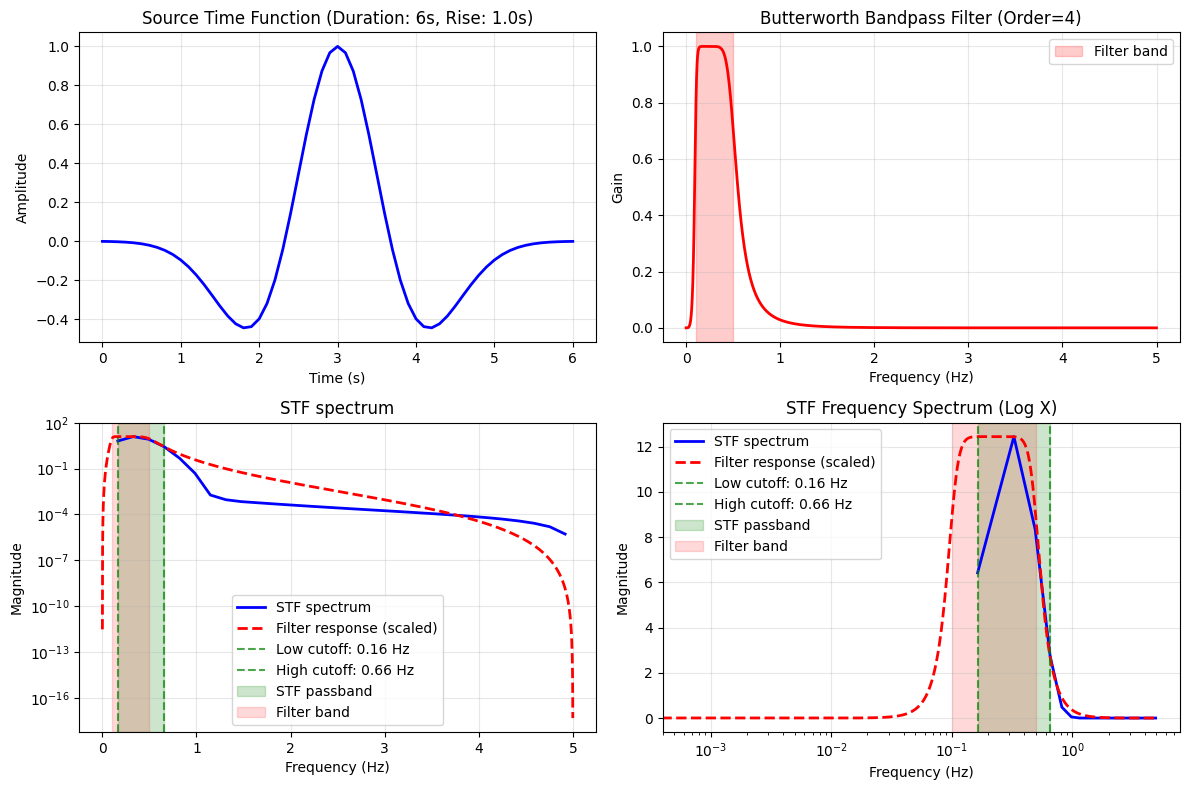

STF duration: 6 seconds
STF passband: 0.16-0.66 Hz
Filter band: 0.1-0.5 Hz
🔴 WARNING: STF low cutoff (0.16 Hz) is above filter min (0.1 Hz)
  STF is removing frequencies that should be preserved!


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# Calculate frequency spectrum
n = len(source_time_function)  # Get the number of points in the STF
freq = fftfreq(n, delta)       # Create frequency axis from -Nyquist to +Nyquist (Hz)
fft_stf = fft(source_time_function)  # Convert STF from time domain to frequency domain
magnitude = np.abs(fft_stf)    # Get the amplitude (magnitude) at each frequency

# Frequency domain: get positive frequencies and their magnitudes
positive_freq_mask = freq > 0  # Create mask for positive frequencies only
freq_pos = freq[positive_freq_mask]
mag_pos = magnitude[positive_freq_mask]

# ------Find cutoff frequencies
max_amp = np.max(mag_pos)
threshold = 0.1 * max_amp

# Find all indices where magnitude is above threshold
above_10_mask = mag_pos >= threshold

if np.any(above_10_mask):
    # Get all frequencies above threshold
    freqs_above = freq_pos[above_10_mask]
    print(f"Frequencies above 10% max: {freqs_above[0]:.2f} to {freqs_above[-1]:.2f} Hz")
    # Set low and high cutoff
    low_cutoff_freq = freqs_above[0]
    high_cutoff_freq = freqs_above[-1]
else:
    print("🔴 WARNING: No frequencies above 10% of max amplitude.")
    low_cutoff_freq = None
    high_cutoff_freq = None

# ------Plot filter, STF and frequency spectrum for both
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
ax1 = axes[0, 0]  # Top left
ax2 = axes[0, 1]  # Top right
ax3 = axes[1, 0]  # Bottom left
ax4 = axes[1, 1]  # Bottom right

# ---Time domain
time_stf = np.arange(len(source_time_function)) * delta  # Create time axis (seconds)
ax1.plot(time_stf, source_time_function, 'b-', linewidth=2)  # Plot STF in time domain
ax1.set_title(f'Source Time Function (Duration: {dura}s, Rise: {rise}s)')  # Set title with parameters
ax1.set_xlabel('Time (s)')     # Label x-axis
ax1.set_ylabel('Amplitude')    # Label y-axis
ax1.grid(True, alpha=0.3)      # Add grid with transparency

# ---Filter parameters (from config)
from scipy.signal import butter, freqz
# Filter parameters
freqmin = config.freqmin
freqmax = config.freqmax
corners = config.corners
fs = 1.0 / config.dt  # Sampling frequency
# Design Butterworth bandpass filter
nyq = 0.5 * fs  # Calculate the Nyquist frequency (half the sampling rate)
low = freqmin / nyq  # Normalize the lower cutoff frequency (as a fraction of Nyquist)
high = freqmax / nyq  # Normalize the upper cutoff frequency (as a fraction of Nyquist)
b, a = butter(corners, [low, high], btype='band')  
# Design a Butterworth bandpass filter of order 'corners' with normalized cutoff frequencies.
# 'b' and 'a' are the filter coefficients for the numerator and denominator, respectively.
w, h = freqz(b, a, worN=8000)  
# Compute the frequency response of the filter.
# 'w' is an array of frequencies (in radians/sample), 'h' is the complex frequency response.
f = w * fs / (2 * np.pi)  
# Convert the frequency array 'w' from radians/sample to Hz for plotting.
# Plotting
ax2.plot(f, abs(h), 'r', linewidth=2)
ax2.set_title(f'Butterworth Bandpass Filter (Order={corners})')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Gain')
ax2.grid(True, alpha=0.3)
ax2.axvspan(freqmin, freqmax, color='red', alpha=0.2, label='Filter band')
ax2.legend()

# ---Frequency domain (log y-axis)
ax3.semilogy(freq_pos, mag_pos, 'b-', linewidth=2, label='STF spectrum')
ax3.plot(f, abs(h) * np.max(mag_pos), 'r--', linewidth=2, label='Filter response (scaled)')
ax3.axvline(x=low_cutoff_freq, color='green', linestyle='--', alpha=0.7, label=f'Low cutoff: {low_cutoff_freq:.2f} Hz')
ax3.axvline(x=high_cutoff_freq, color='green', linestyle='--', alpha=0.7, label=f'High cutoff: {high_cutoff_freq:.2f} Hz')
ax3.axvspan(low_cutoff_freq, high_cutoff_freq, color='green', alpha=0.2, label='STF passband')
ax3.axvspan(config.freqmin, config.freqmax, color='red', alpha=0.15, label='Filter band')
ax3.set_title('STF spectrum')
ax3.set_xlabel('Frequency (Hz)')
ax3.set_ylabel('Magnitude')
ax3.grid(True, alpha=0.3)
ax3.legend()


# ---Frequency domain (log x-axis)
ax4.semilogx(freq_pos, mag_pos, 'b-', linewidth=2, label='STF spectrum')
ax4.plot(f, abs(h) * np.max(mag_pos), 'r--', linewidth=2, label='Filter response (scaled)')
ax4.axvline(x=low_cutoff_freq, color='green', linestyle='--', alpha=0.7, label=f'Low cutoff: {low_cutoff_freq:.2f} Hz')
ax4.axvline(x=high_cutoff_freq, color='green', linestyle='--', alpha=0.7, label=f'High cutoff: {high_cutoff_freq:.2f} Hz')
ax4.axvspan(low_cutoff_freq, high_cutoff_freq, color='green', alpha=0.2, label='STF passband')
ax4.axvspan(config.freqmin, config.freqmax, color='red', alpha=0.15, label='Filter band')
ax4.set_title('STF Frequency Spectrum (Log X)')
ax4.set_xlabel('Frequency (Hz)')
ax4.set_ylabel('Magnitude')
ax4.grid(True, alpha=0.3)
ax4.legend()

plt.tight_layout()
plt.show()

print(f"STF duration: {dura} seconds")
print(f"STF passband: {low_cutoff_freq:.2f}-{high_cutoff_freq:.2f} Hz")
print(f"Filter band: {config.freqmin}-{config.freqmax} Hz")

# Check if STF is limiting your frequency range
if high_cutoff_freq < config.freqmax - .01:
    print(f"🔴 WARNING: STF high cutoff ({high_cutoff_freq:.2f} Hz) is below filter max ({config.freqmax} Hz)")
    print(f"  STF is removing frequencies that should be preserved!")
elif low_cutoff_freq > config.freqmin + .01:
    print(f"🔴 WARNING: STF low cutoff ({low_cutoff_freq:.2f} Hz) is above filter min ({config.freqmin} Hz)")
    print(f"  STF is removing frequencies that should be preserved!")
else:
    print(f"🟢 STF passband ({low_cutoff_freq:.2f}-{high_cutoff_freq:.2f} Hz) covers the filter band ({config.freqmin}-{config.freqmax} Hz)")

# Calculate synthetic waveforms

In [9]:
# # We hard-coded the source mechanism when defining the source. 
# # If we had not done that, we would have had to use the following code to calculate the source mechanism:

# from pyfk.tests.sync.test_sync import TestFunctionCalculateSync  # Import a test utility to get a sample GCMT file path
# test_gcmt_path = TestFunctionCalculateSync.get_sample_gcmt_file_path()  # Get the file path to a sample global CMT (Centroid Moment Tensor) solution file
# with open(test_gcmt_path, "r") as f:  # Open the CMT file for reading
#     for line in f:                    # Loop through each line in the file
#         print(line, end='')           # Print the line (display the contents of the CMT file)

# from pyfk import calculate_sync  # Import synthetic calculator
# event = obspy.read_events(test_gcmt_path)[0]  # Use ObsPy to read the first event from the CMT file (parses the earthquake source mechanism)
# source_prem.update_source_mechanism(event)    # Update the source_prem object with the source mechanism from the event; UPDATES config_prem.source (used below!!)
# sync_result = calculate_sync(gf, config_prem, 30, source_time_function)  # Calculate synthetic seismograms using the Green's functions, config, azimuth (30°), and source time function

# print(sync_result[0]) # prints Z, R, T components (vertical, radial, transverse)

In [10]:
from pyfk import calculate_sync

## Calculate synthetics for selected receiver distance and azimuth
def calculate_synthetics_selected(gfs, config_obj, source_time_function, receiver_distance, azimuth):
    """
    Calculate synthetics for a specific receiver distance and azimuth.
    
    Parameters:
    -----------
    gfs : list
        List of Green's functions for all receivers
    config_obj : Config
        PyFK configuration object
    source_time_function : array
        Source time function
    receiver_distance : float
        Distance in km (must match one of the distances in config.receivers)
    azimuth : float
        Azimuth in degrees
    
    Returns:
    --------
    selected_synthetic : list
        See print statements at end of function for structure of selected_synthetic
    """
    
    # Find the receiver index that matches the requested distance
    try:
        receiver_idx = config.receivers.index(receiver_distance)
    except ValueError:
        available_distances = config.receivers
        raise ValueError(f"Receiver distance {receiver_distance} km not found. Available distances: {available_distances}")
    
    # Get the Green's function for this receiver
    receiver_gf = gfs[receiver_idx]
    
    # Calculate synthetic for the specified azimuth
    print(f"Calculating synthetic for azimuth {azimuth}° at receiver {receiver_distance} km")
    synthetic = calculate_sync(receiver_gf, config_obj, azimuth, source_time_function)
    
    print(f"Synthetic calculated successfully:")
    print(f"  Receiver: {receiver_distance} km")
    print(f"  Azimuth: {azimuth}°")
    print(f"  Components: {len(synthetic)} (Z, R, T)")
    
    return synthetic

selected_distance = config.receivers[-1]
selected_azimuth = config.azimuths[-1] 
selected_synthetic = calculate_synthetics_selected(gfs, config_obj, source_time_function, selected_distance, selected_azimuth)

# Understand structure of selected synthetic
print("selected_synthetic is a list with one item:")
print(selected_synthetic)
print("selected_synthetic[0] is the collection of 3 traces:")
print(selected_synthetic[0])
print("selected_synthetic[0][0] is the first trace:")
print(selected_synthetic[0][0])
print("selected_synthetic[0][0].stats gives the stats of the first trace:")
print(selected_synthetic[0][0].stats)

print("order: BHZ, BHR, BHT")


Calculating synthetic for azimuth 338.7917025818065° at receiver 367.2989756370781 km
Synthetic calculated successfully:
  Receiver: 367.2989756370781 km
  Azimuth: 338.7917025818065°
  Components: 1 (Z, R, T)
selected_synthetic is a list with one item:
selected_synthetic[0] is the collection of 3 traces:
3 Trace(s) in Stream:
... | 1970-01-01T00:00:49.251850Z - 1970-01-01T00:04:13.951850Z | 10.0 Hz, 2048 samples
... | 1970-01-01T00:00:49.251850Z - 1970-01-01T00:04:13.951850Z | 10.0 Hz, 2048 samples
... | 1970-01-01T00:00:49.251850Z - 1970-01-01T00:04:13.951850Z | 10.0 Hz, 2048 samples
selected_synthetic[0][0] is the first trace:
... | 1970-01-01T00:00:49.251850Z - 1970-01-01T00:04:13.951850Z | 10.0 Hz, 2048 samples
selected_synthetic[0][0].stats gives the stats of the first trace:
         network: 
         station: 
        location: 
         channel: 
       starttime: 1970-01-01T00:00:49.251850Z
         endtime: 1970-01-01T00:04:13.951850Z
   sampling_rate: 10.0
           delta

## Plot all synthetics

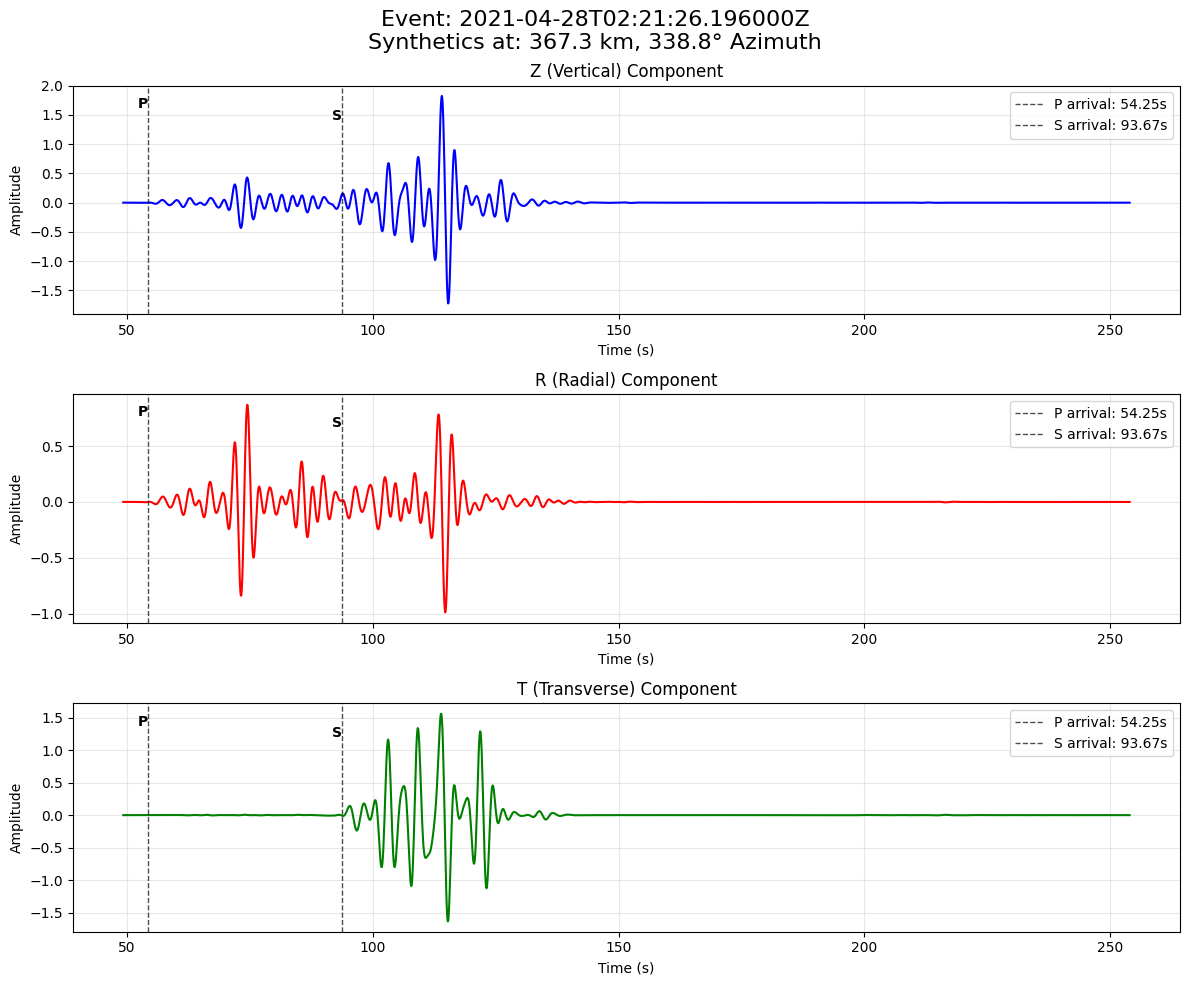

In [11]:
def process_component(component, config):
    """Process a single component with standard filtering"""
    filtered_trace = component.copy()
    filtered_trace.detrend("linear")
    filtered_trace.taper(max_percentage=0.05, type='hann')
    filtered_trace.filter("bandpass", freqmin=config.freqmin, freqmax=config.freqmax, 
                         corners=config.corners, zerophase=True)
    return filtered_trace

def plot_selected_synthetic(selected_synthetic, receiver_distance, azimuth, config, event_time=None):
    """Plot the selected synthetic waveform with 3 components (Z, N, E)"""
    
    # Get the stream containing the 3 components
    stream = selected_synthetic[0]
    
    # Create subplots for all three components
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))
    
    # Set the main title with receiver info and event time
    if event_time:
        title = f'Event: {event_time}\nSynthetics at: {receiver_distance:.1f} km, {azimuth:.1f}° Azimuth'
    else:
        title = f'Synthetics: {receiver_distance:.1f} km, {azimuth:.1f}° Azimuth'
    
    fig.suptitle(title, fontsize=16)
    
    component_names = ['Z (Vertical)', 'R (Radial)', 'T (Transverse)']
    colors = ['blue', 'red', 'green']
    
    for i, (component, comp_name, color) in enumerate(zip(stream, component_names, colors)):
        ax = axes[i]
        
        # Get time axis
        time = np.arange(len(component.data)) * component.stats.delta + component.stats.sac.b
        
        # Process component with filtering
        filtered_trace = process_component(component, config)
        
        # Plot
        ax.plot(time, filtered_trace.data, color=color, linewidth=1.5)
        ax.set_title(f'{comp_name} Component')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Amplitude')
        ax.grid(True, alpha=0.3)
        
        # Add P and S arrival markers from SAC headers
        if hasattr(component.stats.sac, 't1') and component.stats.sac.t1 != -12345:
            p_time = component.stats.sac.t1
            ax.axvline(x=p_time, color='black', linestyle='--', linewidth=1, alpha=0.7, label=f'P arrival: {p_time:.2f}s')
            ax.text(p_time, ax.get_ylim()[1]*0.9, 'P', color='black', fontweight='bold', 
                   horizontalalignment='right', verticalalignment='top')
        
        if hasattr(component.stats.sac, 't2') and component.stats.sac.t2 != -12345:
            s_time = component.stats.sac.t2
            ax.axvline(x=s_time, color='black', linestyle='--', linewidth=1, alpha=0.7, label=f'S arrival: {s_time:.2f}s')
            ax.text(s_time, ax.get_ylim()[1]*0.8, 'S', color='black', fontweight='bold',
                   horizontalalignment='right', verticalalignment='top')
        
        # Add legend for arrival markers
        ax.legend(loc='upper right')
    
    plt.tight_layout()
    return fig, axes

# Create plot
fig, axes = plot_selected_synthetic(selected_synthetic, selected_distance, selected_azimuth, config, 
                                   event_time=config.event_starttime)
plt.show()

# Request observed waveforms

Only one event should be shown below. If not, edit criteria to narrow.


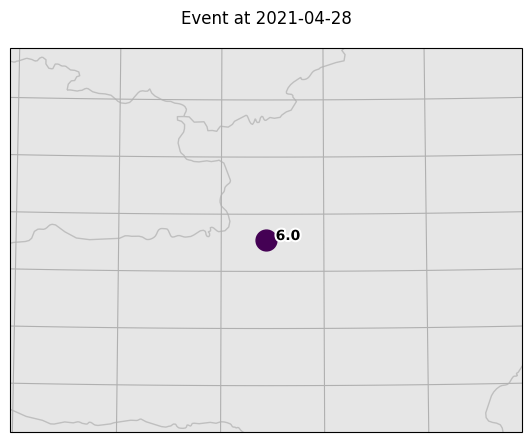

observed_data is a stream with 3 traces:
3 Trace(s) in Stream:
IC.LSA.00.BH1 | 2021-04-28T02:21:26.219536Z - 2021-04-28T02:26:26.169536Z | 20.0 Hz, 6000 samples
IC.LSA.00.BH2 | 2021-04-28T02:21:26.219538Z - 2021-04-28T02:26:26.169538Z | 20.0 Hz, 6000 samples
IC.LSA.00.BHZ | 2021-04-28T02:21:26.219538Z - 2021-04-28T02:26:26.169538Z | 20.0 Hz, 6000 samples
observed_data[0] is the first trace:
IC.LSA.00.BH1 | 2021-04-28T02:21:26.219536Z - 2021-04-28T02:26:26.169536Z | 20.0 Hz, 6000 samples
observed_data[0].stats gives the stats of the first trace:
               network: IC
               station: LSA
              location: 00
               channel: BH1
             starttime: 2021-04-28T02:21:26.219536Z
               endtime: 2021-04-28T02:26:26.169536Z
         sampling_rate: 20.0
                 delta: 0.05
                  npts: 6000
                 calib: 1.0
_fdsnws_dataselect_url: http://service.iris.edu/fdsnws/dataselect/1/query
               _format: MSEED
                

In [12]:
from obspy.clients.fdsn import Client

def get_observed_data(config, network='IC', station='LSA'):
    """Get observed waveform data with error handling"""
    try:
        client = Client("IRIS")
        
        # Get event
        event_endtime = config.event_starttime + 600
        events = client.get_events(
            starttime=config.event_starttime,
            endtime=event_endtime, 
            latitude=config.latitude, 
            longitude=config.longitude, 
            minradius=0, 
            maxradius=(config.receivers[-1] / 100) + 1, 
            minmagnitude=config.magnitude - 1, 
            mindepth=config.source_depth - 60
        )
        
        # Plot events (moved after the query)
        if len(events) > 0:
            events.plot('local')
        if not events:
            raise ValueError("No events found for the specified criteria")
        
        # Get waveforms
        stream = client.get_waveforms(
            network=network, 
            station=station, 
            location='00', 
            channel='BH*', 
            starttime=config.event_starttime, 
            endtime=config.event_starttime + config.shift2 # ARBITRARY VALUE TO ALLOW SNLG WINDOW TO BE LARGE ENOUGH!!
        )
        logging.info(f"Observed data retrieved: {len(stream)} components")
        
        return stream
        
    except Exception as e:
        logging.error(f"Error getting observed data: {e}")
        raise

print("Only one event should be shown below. If not, edit criteria to narrow.")

# Get observed data
observed_data = get_observed_data(config)

# Understand structure of observed data
print("observed_data is a stream with 3 traces:")
print(observed_data)
print("observed_data[0] is the first trace:")
print(observed_data[0])
print("observed_data[0].stats gives the stats of the first trace:")
print(observed_data[0].stats)
print("the order: BH1, BH2, BHZ")

## Clean data (observed)

### Store observed_data with response + in ZNE for SnLg

In [13]:
observed_data_SnLg = observed_data.copy() # BH1, BH2, BHZ
# Rename BH1 -> BHE, BH2 -> BHN, BHZ stays the same
for tr in observed_data_SnLg:
    if tr.stats.channel.endswith("BH1"):
        tr.stats.channel = tr.stats.channel[:-3] + "BHN"
    elif tr.stats.channel.endswith("BH2"):
        tr.stats.channel = tr.stats.channel[:-3] + "BHE"
    elif tr.stats.channel.endswith("BHZ"):
        tr.stats.channel = tr.stats.channel[:-3] + "BHZ"

# # Double check channel names
# print(observed_data_SnLg[0].stats)
# print(observed_data_SnLg[1].stats)
# print(observed_data_SnLg[2].stats)

### Remove station response

In [14]:
# Fetch response and remove it
from obspy.clients.fdsn import Client
client = Client("IRIS")

inv = client.get_stations(
    network='IC',
    station='LSA',
    location='00',
    channel='BH*',
    starttime=config.event_starttime,
    endtime=config.event_starttime + config.shift2,
    level='response'
)
observed_data = observed_data.remove_response(inventory=inv, output='VEL') # Other options: 'DISP', 'ACC'
observed_data2 = observed_data.copy() # store BH1, BH2, ZNE copy for comparison with rotated ZRT observed

### Rotate observed_data from BH1, BH2, BHZ to BHR, BHT, BHZ

Before rotation, BH1, BH2, BHZ corresponds to BHN, BHE, BHZ
Channel: BH1
  Azimuth: 0.0
  Dip: 0.0
  Description: None

Channel: BH2
  Azimuth: 90.0
  Dip: 0.0
  Description: None

Channel: BHZ
  Azimuth: 0.0
  Dip: -90.0
  Description: None

After rotation,the NEW order: BHZ, BHR, BHT


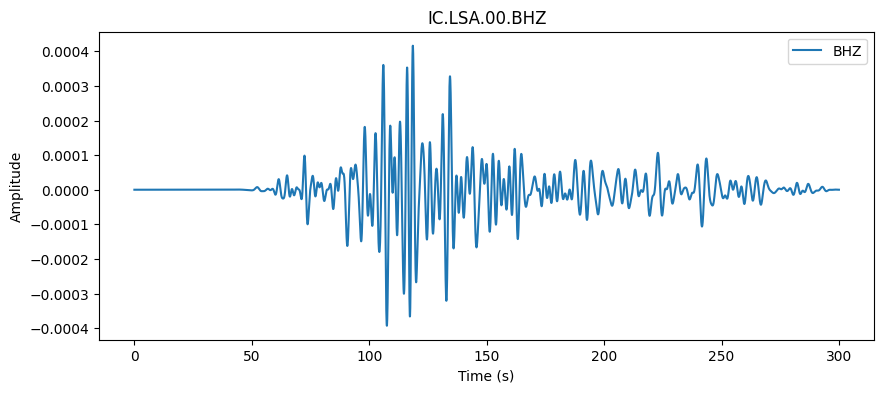

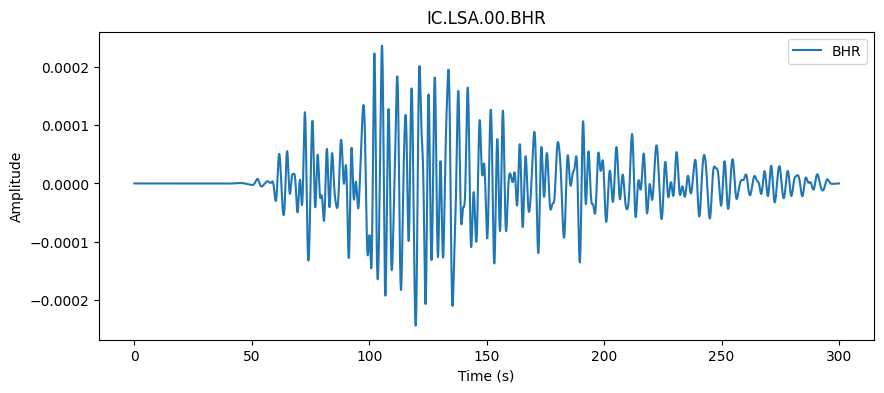

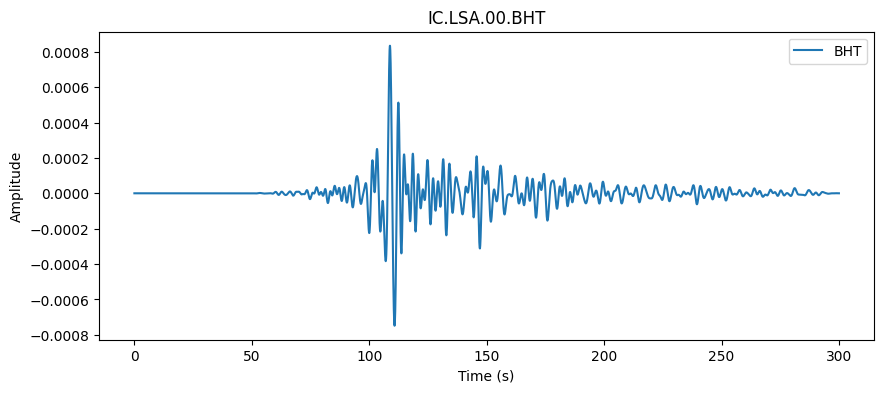

In [15]:
# Check current orientation
# Check the orientation information
print("Before rotation, BH1, BH2, BHZ corresponds to BHN, BHE, BHZ")
for net in inv:
    for sta in net.stations:
        for cha in sta.channels:
            print(f"Channel: {cha.code}")
            print(f"  Azimuth: {cha.azimuth}")
            print(f"  Dip: {cha.dip}")
            print(f"  Description: {cha.description}")
            print()

# Rename BH1 -> BHE, BH2 -> BHN, BHZ stays the same
for tr in observed_data:
    if tr.stats.channel.endswith("BH1"):
        tr.stats.channel = tr.stats.channel[:-3] + "BHN"
    elif tr.stats.channel.endswith("BH2"):
        tr.stats.channel = tr.stats.channel[:-3] + "BHE"
    elif tr.stats.channel.endswith("BHZ"):
        tr.stats.channel = tr.stats.channel[:-3] + "BHZ"

# Rotate from NE to RT (Z stays the same)
baz = config.back_azimuth
observed_data.rotate(method='NE->RT', back_azimuth=baz)

# Order components: ZRT
from obspy import Stream
channels_order = ['BHZ', 'BHR', 'BHT']
ordered_traces = [next(tr for tr in observed_data if tr.stats.channel.endswith(ch)) for ch in channels_order]
observed_data = Stream(traces=ordered_traces)
print("After rotation,the NEW order: BHZ, BHR, BHT")
# print(observed_data[0].stats) # to confirm the new order
# print(observed_data[1].stats)
# print(observed_data[2].stats)

# Plot the rotated data
import matplotlib.pyplot as plt
import numpy as np
observed_dataP = process_component(observed_data, config)
for tr in observed_dataP:
    # Create a time array in seconds since trace start
    t = np.arange(tr.stats.npts) * tr.stats.delta
    plt.figure(figsize=(10, 4))
    plt.plot(t, tr.data, label=tr.stats.channel)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(f"{tr.id}")
    plt.legend()
    plt.show()

### Check rotation

In [16]:
# import matplotlib.pyplot as plt
# import numpy as np
# from obspy.taup import TauPyModel
# from obspy.geodetics import kilometers2degrees

# # Calculate P arrival time
# model = TauPyModel(model="iasp91")
# deg = kilometers2degrees(distance_select)
# arrivals = model.get_travel_times(source_depth_in_km=config.source_depth, distance_in_degree=deg, phase_list=['p', 'P'])

# if arrivals:
#     p_arrival_time = arrivals[0].time
#     print(f"P arrival time: {p_arrival_time:.2f} seconds")
# else:
#     print("No P arrivals found!")
#     p_arrival_time = 0  # fallback value

# # Create subplots: 3 rows, 2 columns
# fig, axes = plt.subplots(3, 2, figsize=(15, 10))
# fig.suptitle(f'Observed Data Comparison: Before vs After Rotation (No Filter)\nEvent: {config.event_starttime}, Azimuth: {config.azimuths[-1]}°', fontsize=16)

# # Left column: observed_data2 (BH1, BH2, BHZ)
# left_labels = ['BH1 (North)', 'BH2 (East)', 'BHZ (Vertical)']
# for i in range(3):
#     ax = axes[i, 0]
#     trace = observed_data2[i]
    
#     # Time axis
#     dt = trace.stats.delta
#     t = np.arange(len(trace.data)) * dt
    
#     # Plot trace
#     ax.plot(t, trace.data, 'r-', linewidth=1)
#     ax.set_title(f'{left_labels[i]} (Before Rotation)')
#     ax.set_xlabel('Time (s)')
#     ax.set_ylabel('Amplitude')
#     ax.grid(True, alpha=0.3)
    
#     # Mark P arrival
#     ax.axvline(x=p_arrival_time, color='blue', linestyle='--', alpha=0.7, label=f'P arrival ({p_arrival_time:.1f}s)')
#     ax.legend()

# # Right column: observed_data (BHZ, BHR, BHT)
# right_labels = ['BHZ (Vertical)', 'BHR (Radial)', 'BHT (Transverse)']
# for i in range(3):
#     ax = axes[i, 1]
#     trace = observed_data[i]
    
#     # Time axis
#     dt = trace.stats.delta
#     t = np.arange(len(trace.data)) * dt
    
#     # Plot trace
#     ax.plot(t, trace.data, 'b-', linewidth=1)
#     ax.set_title(f'{right_labels[i]} (After Rotation)')
#     ax.set_xlabel('Time (s)')
#     ax.set_ylabel('Amplitude')
#     ax.grid(True, alpha=0.3)
    
#     # Mark P arrival
#     ax.axvline(x=p_arrival_time, color='blue', linestyle='--', alpha=0.7, label=f'P arrival ({p_arrival_time:.1f}s)')
#     ax.legend()

# plt.tight_layout()
# plt.show()

# # Print P wave amplitudes for each component
# print("\n" + "="*60)
# print("P WAVE AMPLITUDE COMPARISON (No Filter)")
# print("="*60)

# # Calculate P wave amplitudes (no filtering)
# p_window_start = p_arrival_time - 1.0
# p_window_end = p_arrival_time + 5.0

# print("\nBEFORE ROTATION (observed_data2):")
# for i, trace in enumerate(observed_data2):
#     dt = trace.stats.delta
#     t = np.arange(len(trace.data)) * dt
#     p_start_idx = np.argmin(np.abs(t - p_window_start))
#     p_end_idx = np.argmin(np.abs(t - p_window_end))
#     p_data = trace.data[p_start_idx:p_end_idx]
#     p_max_amp = np.max(np.abs(p_data))
#     print(f"  {left_labels[i]}: Max P amplitude = {p_max_amp:.6f}")

# print("\nAFTER ROTATION (observed_data):")
# for i, trace in enumerate(observed_data):
#     dt = trace.stats.delta
#     t = np.arange(len(trace.data)) * dt
#     p_start_idx = np.argmin(np.abs(t - p_window_start))
#     p_end_idx = np.argmin(np.abs(t - p_window_end))
#     p_data = trace.data[p_start_idx:p_end_idx]
#     p_max_amp = np.max(np.abs(p_data))
#     print(f"  {right_labels[i]}: Max P amplitude = {p_max_amp:.6f}")

# # Calculate amplitude ratios
# print("\nAMPLITUDE RATIOS (After/Before):")
# # before: bhn, bhe, bhz; after: bhz, bhr, bht; use NE->RT
# bhz_ratio = np.max(np.abs(observed_data[0].data[p_start_idx:p_end_idx])) / np.max(np.abs(observed_data2[2].data[p_start_idx:p_end_idx]))
# bhr_ratio = np.max(np.abs(observed_data[1].data[p_start_idx:p_end_idx])) / np.max(np.abs(observed_data2[0].data[p_start_idx:p_end_idx]))  # BHR vs BH1 (North)
# bht_ratio = np.max(np.abs(observed_data[2].data[p_start_idx:p_end_idx])) / np.max(np.abs(observed_data2[1].data[p_start_idx:p_end_idx]))  # BHT vs BH2 (East)

# print(f"  BHZ ratio: {bhz_ratio:.3f} (should be ~1.0)")
# print(f"  BHR ratio: {bhr_ratio:.3f} (should be >1.0 for larger P amplitude)")
# print(f"  BHT ratio: {bht_ratio:.3f} (should be <1.0 for smaller P amplitude)")

# Compute SnLg on observed and synthetic

In [17]:
import sys
sys.path.append("/Users/emmanuelzheng/Downloads/Synthetics")

# --- 1. Imports ---
from SnLg.snlg_analyses import SnLg_Analyses, SnLg_OneEventStationPair
from obspy.geodetics import gps2dist_azimuth, kilometer2degrees
from obspy.taup import TauPyModel
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

# --- 2. Prepare event and station metadata ---
event = {
    'event_lon': config.longitude,
    'event_lat': config.latitude,
    'event_dep': config.source_depth,
    'event_time': config.event_starttime,
    'event_mag': config.magnitude
}

# Download inventory with response info for the correct time window
client = Client("IRIS")
network_code = "IC"
station_code = "LSA"
inventory = client.get_stations(
    network=network_code,
    station=station_code,
    channel="BH?",
    starttime=config.event_starttime,
    endtime=config.event_starttime,
    level="response"
)

# Get the station object for LSA from your inventory
station = None
for net in inventory:
    if net.code == network_code:
        for stn in net.stations:
            if stn.code == station_code:
                station = stn
                break
if station is None:
    raise ValueError("Station LSA not found in inventory!")

# --- 3. Prep synthetic ---
selected_synthetic_SnLg = selected_synthetic[0].copy()
# Assign channel codes to synthetic traces (Z, R, T components)
channel_codes = ['BHZ', 'BHR', 'BHT'] 
for i, tr in enumerate(selected_synthetic_SnLg):
    tr.stats.channel = channel_codes[i]
# Rotate to ZNE
selected_synthetic_SnLg.rotate('RT->NE', back_azimuth=baz) # baz already calculated prior
# Set synthetic trace to start at event time + b_time
for tr in selected_synthetic_SnLg:
    b_time = tr.stats.sac.b if hasattr(tr.stats, 'sac') and hasattr(tr.stats.sac, 'b') else 0.0
    tr.stats.starttime = event['event_time'] + b_time

# --- 4. Calculate distance, azimuth, and p_arrival ---
evla = event['event_lat']
evlo = event['event_lon']
evdp = event['event_dep']
stla = station.latitude
stlo = station.longitude
dist_m, baz, _ = gps2dist_azimuth(stla, stlo, evla, evlo)
dist = dist_m / 1000.0  # km
gcarc = kilometer2degrees(dist)
model = TauPyModel(model="iasp91")
arrivals = model.get_travel_times(source_depth_in_km=evdp, distance_in_degree=gcarc, phase_list=['p', 'P'])
p_arrival = event['event_time'] + arrivals[0].time if arrivals else None

# --- 5a. Create the SnLg_Analyses object for observed waveform ---
snlg_analyzer1 = SnLg_Analyses(
    enable_write_sac=False,
    enable_archive_waveform=False
)

# --- 5b. Create the SnLg_Analyses object for synthetic waveform ---
snlg_analyzer2 = SnLg_Analyses(
    enable_write_sac=False,
    enable_archive_waveform=False
)

# --- 6a. Set up the event-station pair dataclass for observed waveform ---
snlg_analyzer1.snlg_onepair = SnLg_OneEventStationPair(
    event=event,
    station=station,
    evla = event['event_lat'],
    evlo = event['event_lon'],
    evdp = event['event_dep'],
    mag=event['event_mag'],
    origin_time=event['event_time'],
    stla=stla,
    stlo=stlo,
    stel=station.elevation,
    kstnm=station.code,
    knetwk=network_code,
    gcarc=gcarc,
    dist=dist,
    baz=baz,
    p_arrival=p_arrival,
    vsm=4.7,
    vsc=3.7,
    moho_snlg=55,
    sn_filt=(0.01, 0.4),
    lg_filt=(0.01, 0.4)
)

# --- 6b. Set up the event-station pair dataclass for synthetic waveform ---
snlg_analyzer2.snlg_onepair = SnLg_OneEventStationPair(
    event=event,
    station=station,
    evla = event['event_lat'],
    evlo = event['event_lon'],
    evdp = event['event_dep'],
    mag=event['event_mag'],
    origin_time=event['event_time'],
    stla=stla,
    stlo=stlo,
    stel=station.elevation,
    kstnm=station.code,
    knetwk=network_code,
    gcarc=gcarc,
    dist=dist,
    baz=baz,
    p_arrival=p_arrival,
    vsm=4.7,
    vsc=3.7,
    moho_snlg=55,
    sn_filt=(0.01, 0.4),
    lg_filt=(0.01, 0.4)
)

# --- 7a. Run the analysis on observed waveform stream ---
snlg_analyzer1.process_snlg_one_stream(observed_data_SnLg)

# --- 7b. Run the analysis on synthetic waveform stream ---
snlg_analyzer2.process_snlg_one_stream(selected_synthetic_SnLg)

# --- 8a. Get the results from observed waveform stream ---
print("Observed Sn/Lg raw ratio (ln):", snlg_analyzer1.snlg_onepair.SnRLg_raw)
print("Observed Sn/Lg corrected ratio (ln):", snlg_analyzer1.snlg_onepair.SnRLg_cor)
print("Observed SNR:", snlg_analyzer1.snlg_onepair.SNR)
print("Observed Trace start:", observed_data_SnLg[0].stats.starttime)
print("Observed Trace end:", observed_data_SnLg[0].stats.endtime)
print("Observed Noise window:", snlg_analyzer1.snlg_onepair.noise_window)
print("Observed Sn window:", snlg_analyzer1.snlg_onepair.sn_window)
print("Observed Lg window:", snlg_analyzer1.snlg_onepair.lg_window)

# --- 8b. Get the results from synthetic waveform stream ---
print("Synthetic Sn/Lg raw ratio (ln):", snlg_analyzer2.snlg_onepair.SnRLg_raw)
print("Synthetic Sn/Lg corrected ratio (ln):", snlg_analyzer2.snlg_onepair.SnRLg_cor)
print("Synthetic SNR:", snlg_analyzer2.snlg_onepair.SNR)
print("Synthetic Trace start:", selected_synthetic_SnLg[0].stats.starttime)
print("Synthetic Trace end:", selected_synthetic_SnLg[0].stats.endtime)
print("Synthetic Noise window:", snlg_analyzer2.snlg_onepair.noise_window)
print("Synthetic Sn window:", snlg_analyzer2.snlg_onepair.sn_window)
print("Synthetic Lg window:", snlg_analyzer2.snlg_onepair.lg_window)

INFO:SnLg.snlg_analyses:Success rotated to RTZ coordinate system for event (2021-04-28T02:21:26.196000Z)
INFO:SnLg.snlg_analyses:Success in calculating Sn and Lg arrivals for event (2021-04-28T02:21:26.196000Z)
INFO:SnLg.snlg_analyses:Proceeding to calculate Sn/Lg for event (2021-04-28T02:21:26.196000Z)
INFO:SnLg.snlg_analyses:Success in beginning formal Sn/Lg computation for event (2021-04-28T02:21:26.196000Z)
INFO:SnLg.snlg_analyses:Success in obtaining Sn and Lg traces for event (2021-04-28T02:21:26.196000Z)
INFO:SnLg.snlg_analyses:Success in calculating RMS amplitude of noise, Sn, and Lg.
INFO:SnLg.snlg_analyses:Success rotated to RTZ coordinate system for event (2021-04-28T02:21:26.196000Z)
INFO:SnLg.snlg_analyses:Success in calculating Sn and Lg arrivals for event (2021-04-28T02:21:26.196000Z)
INFO:SnLg.snlg_analyses:Proceeding to calculate Sn/Lg for event (2021-04-28T02:21:26.196000Z)
INFO:SnLg.snlg_analyses:Success in beginning formal Sn/Lg computation for event (2021-04-28T02:

Observed Sn/Lg raw ratio (ln): -1.878117312315745
Observed Sn/Lg corrected ratio (ln): -1.8017284621849694
Observed SNR: 8963.816472839084
Observed Trace start: 2021-04-28T02:21:26.219536Z
Observed Trace end: 2021-04-28T02:26:26.169536Z
Observed Noise window: (UTCDateTime(2021, 4, 28, 2, 21, 50, 827515), UTCDateTime(2021, 4, 28, 2, 22, 10, 827515))
Observed Sn window: (88.82255923693215, 98.7769713663891)
Observed Lg window: (98.7769713663891, 114.46716683594559)
Synthetic Sn/Lg raw ratio (ln): -2.0713584616517893
Synthetic Sn/Lg corrected ratio (ln): -1.9949696115210136
Synthetic SNR: nan
Synthetic Trace start: 2021-04-28T02:22:15.447850Z
Synthetic Trace end: 2021-04-28T02:25:40.147850Z
Synthetic Noise window: (UTCDateTime(2021, 4, 28, 2, 21, 50, 827515), UTCDateTime(2021, 4, 28, 2, 22, 10, 827515))
Synthetic Sn window: (88.82255923693215, 98.7769713663891)
Synthetic Lg window: (98.7769713663891, 114.46716683594559)


# Pinning down phase arrivals

## Build TauP model; add in rho, Qs, Qp parameters

In [18]:
# --- 1. Write the Tibetan_model.nd file from your parameters ---
with open('Tibetan_model.nd', 'w') as fw:
    # Layer 1: 0 to 3 km
    fw.write(f"{0:6.2f}{5.8:6.3f}{3.3:6.3f}    2.6    1200    600\n") # surface properties
    fw.write(f"{3.0:6.2f}{5.8:6.3f}{3.3:6.3f}    2.6    1200    600\n")
    # Layer 2: 3 to 40 km
    fw.write(f"{3:6.2f}{5.8:6.3f}{3.5:6.3f}    2.8    1200    600\n")
    fw.write(f"{40.0:6.2f}{5.8:6.3f}{3.5:6.3f}    2.8    1200    600\n")
    # Layer 3: 40 to 70 km
    fw.write(f"{40.0:6.2f}{6.9:6.3f}{4.0:6.3f}    3.3    1200    600\n")
    fw.write(f"{70.0:6.2f}{6.9:6.3f}{4.0:6.3f}    3.3    1200    600\n")
    fw.write("mantle\n") # denotes mantle begins below
    # Layer 4: 70 to 6371 km (mantle)
    fw.write(f"{70.0:6.2f}{8.6:6.3f}{4.9:6.3f}    3.5    1200    600\n")
    fw.write(f"{6371.0:6.2f}{8.6:6.3f}{4.9:6.3f}    3.5    1200    600\n")

# --- 2. Build the TauPyModel .npz file ---
from obspy.taup import taup_create
taup_create.build_taup_model('Tibetan_model.nd', '.')

# --- 3. Use with TauPyModel ---
from obspy.taup import TauPyModel
model = TauPyModel(model='Tibetan_model.npz')

Building obspy.taup model for 'Tibetan_model.nd' ...
filename = Tibetan_model.nd
Done reading velocity model.
Radius of model . is 6371.0
Using parameters provided in TauP_config.ini (or defaults if not) to call SlownessModel...
Parameters are:
taup.create.min_delta_p = 0.1 sec / radian
taup.create.max_delta_p = 11.0 sec / radian
taup.create.max_depth_interval = 115.0 kilometers
taup.create.max_range_interval = 0.04363323129985824 degrees
taup.create.max_interp_error = 0.05 seconds
taup.create.allow_inner_core_s = True
Slow model  328 P layers,507 S layers
Done calculating Tau branches.
Done Saving Tibetan_model.npz
Method run is done, but not necessarily successful.


## Get phase arrivals

37 arrivals
	P phase arrival at 53.842 seconds
	Pn phase arrival at 53.844 seconds
	P phase arrival at 57.584 seconds
	P phase arrival at 58.375 seconds
	pP phase arrival at 61.561 seconds
	pP phase arrival at 63.262 seconds
	p phase arrival at 63.382 seconds
	P phase arrival at 63.677 seconds
	pP phase arrival at 64.429 seconds
	PP phase arrival at 65.116 seconds
	sP phase arrival at 65.627 seconds
	pP phase arrival at 65.932 seconds
	PP phase arrival at 66.972 seconds
	sP phase arrival at 67.905 seconds
	sP phase arrival at 68.935 seconds
	PP phase arrival at 69.308 seconds
	PP phase arrival at 69.867 seconds
	sP phase arrival at 70.233 seconds
	sP phase arrival at 71.634 seconds
	S phase arrival at 92.963 seconds
	Sn phase arrival at 92.966 seconds
	S phase arrival at 98.302 seconds
	S phase arrival at 99.726 seconds
	sS phase arrival at 105.253 seconds
	s phase arrival at 105.257 seconds
	S phase arrival at 105.718 seconds
	sS phase arrival at 106.933 seconds
	sS phase arrival at 1

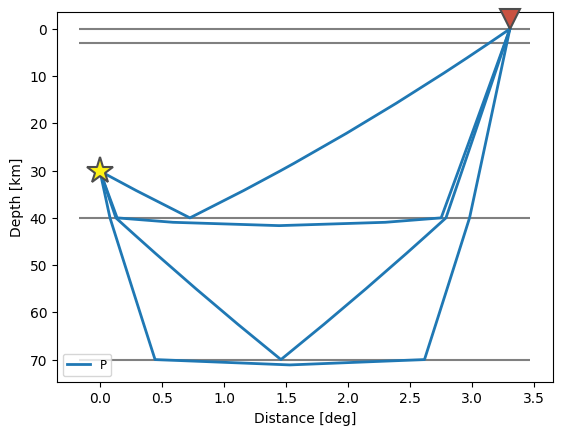

<Axes: xlabel='Distance [deg]', ylabel='Depth [km]'>

In [19]:
from obspy.taup import TauPyModel
from obspy.geodetics import kilometers2degrees

deg = kilometers2degrees(distance_select)
arrivals = model.get_travel_times(source_depth_in_km=config.source_depth, distance_in_degree=deg)
print(arrivals)

arrivalsPlot = model.get_ray_paths(source_depth_in_km=config.source_depth, distance_in_degree=deg, phase_list=["P"])
arrivalsPlot.plot_rays(plot_type='cartesian', phase_list=["P"],
                   plot_all=False, legend=True)

# Plot synthetics on top of observed waveforms

## Get max P wave amplitude for Z component of synthetic + observed

In [20]:
# Get P wave arrival time from synthetic SAC headers
p_arrival_time = selected_synthetic[0][0].stats.sac.t1  # P arrival time in seconds
s_arrival_time = selected_synthetic[0][0].stats.sac.t2  # S arrival time in seconds

# Define P wave window
p_window_start = p_arrival_time - 5.0 
p_window_end = s_arrival_time - 5.0

# Get time axis for synthetic
b_time = selected_synthetic[0][0].stats.sac.b
t_syn = np.arange(len(selected_synthetic[0][0].data)) * selected_synthetic[0][0].stats.delta + b_time

# Find indices for P wave window
p_start_idx = np.argmin(np.abs(t_syn - p_window_start))
p_end_idx = np.argmin(np.abs(t_syn - p_window_end))

# Extract P wave data for synthetic Z component
synthetic_p_wave = selected_synthetic[0][0].data[p_start_idx:p_end_idx]
synthetic_p_max_amp = np.max(np.abs(synthetic_p_wave))
print(f"Maximum amplitude of synthetic Z component P wave: {synthetic_p_max_amp}")

# Get time axis for observed
dt_obs = observed_data[0].stats.delta
t_obs = np.arange(len(observed_data[0].data)) * dt_obs

# Find indices for P wave window in observed data
p_start_idx_obs = np.argmin(np.abs(t_obs - p_window_start))
p_end_idx_obs = np.argmin(np.abs(t_obs - p_window_end))

# Extract P wave data for observed Z component
observed_p_wave = observed_data[0].data[p_start_idx_obs:p_end_idx_obs]
observed_p_max_amp = np.max(np.abs(observed_p_wave))
print(f"Maximum amplitude of observed Z component P wave: {observed_p_max_amp}")

Maximum amplitude of synthetic Z component P wave: 0.5012985642581959
Maximum amplitude of observed Z component P wave: 0.0002205756791677999


## Plot

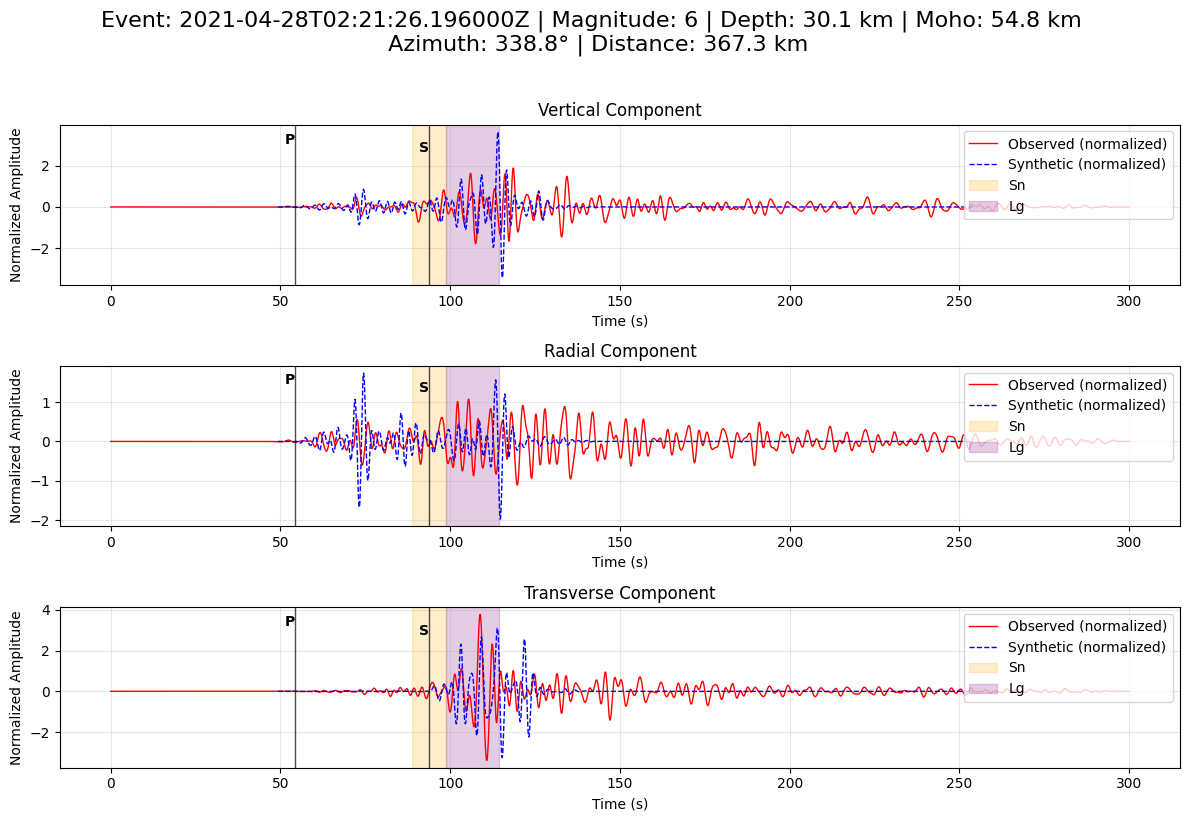

In [28]:
# Create subplots for all three components
fig, axes = plt.subplots(3, 1, figsize=(12, 8))
fig.suptitle(f"Event: {config.event_starttime} | Magnitude: {config.magnitude} | Depth: {config.source_depth} km | Moho: {config.moho_depth} km \n Azimuth: {selected_azimuth:.1f}° | Distance: {selected_distance:.1f} km", fontsize=16, y=1.02)
component_names = ['Vertical', 'Radial', 'Transverse']

for i, synthetic_component in enumerate(selected_synthetic[0]):
    # Process observed and synthetic components
    observed_component = process_component(observed_data[i], config)
    synthetic_data = process_component(synthetic_component.copy(), config)
    
    # Get time axis for synthetic
    b_time = synthetic_component.stats.sac.b if hasattr(synthetic_component.stats, 'sac') and hasattr(synthetic_component.stats.sac, 'b') else 0.0
    t_syn = np.arange(len(synthetic_component.data)) * synthetic_component.stats.delta + b_time
    # Get time axis for observed (assuming all have same sampling rate)
    dt_obs = observed_data[0].stats.delta
    t_obs = np.arange(len(observed_data[0].data)) * dt_obs
    
    # Normalize both observed and synthetic data for comparison
    observed_norm = observed_component.data / observed_p_max_amp 
    synthetic_norm = synthetic_data.data / synthetic_p_max_amp
    # # OR (normal norm)
    # observed_norm = observed_component.data / np.max(np.abs(observed_component.data))
    # synthetic_norm = synthetic_data.data / np.max(np.abs(synthetic_data.data))
    
    # Plot normalized data
    axes[i].plot(t_obs, observed_norm, 'r-', linewidth=1, label='Observed (normalized)')
    axes[i].plot(t_syn, synthetic_norm, 'b--', linewidth=1, label='Synthetic (normalized)')

    # Add P and S arrival markers from synthetic SAC headers
    if hasattr(synthetic_component.stats.sac, 't1') and synthetic_component.stats.sac.t1 != -12345:
        p_time = synthetic_component.stats.sac.t1
        axes[i].axvline(x=p_time, color='black', linestyle='-', linewidth=1, alpha=0.7)
        axes[i].text(p_time, axes[i].get_ylim()[1]*0.9, 'P', color='black', fontweight='bold', 
                    horizontalalignment='right', verticalalignment='top')
    if hasattr(synthetic_component.stats.sac, 't2') and synthetic_component.stats.sac.t2 != -12345:
        s_time = synthetic_component.stats.sac.t2
        axes[i].axvline(x=s_time, color='black', linestyle='-', linewidth=1, alpha=0.7)
        axes[i].text(s_time, axes[i].get_ylim()[1]*0.8, 'S', color='black', fontweight='bold',
                    horizontalalignment='right', verticalalignment='top')

    # Plot calculated Sn and Lg windows (observed and synthetic windows are identical)
    if snlg_analyzer1.snlg_onepair.sn_window is not None:
        sn_start, sn_end = snlg_analyzer1.snlg_onepair.sn_window
    if snlg_analyzer1.snlg_onepair.lg_window is not None:
        lg_start, lg_end = snlg_analyzer1.snlg_onepair.lg_window
    axes[i].axvspan(sn_start, sn_end, color='orange', alpha=0.2, label = 'Sn')
    axes[i].axvspan(lg_start, lg_end, color='purple', alpha=0.2, label = 'Lg')

    # # Plot arrivals from TauPyModel (only if reasonable)
    # for arrival in arrivals:
    #     if arrival.time < lg_end + 20:
    #         # Set color based on arrival name
    #         color = 'purple' if arrival.name in ('P', 'S') else 'black'
    #         lw = 5 if arrival.name in ('P', 'S') else 1
    #         axes[i].axvline(x=arrival.time, color=color, linestyle='-', linewidth=lw, alpha=0.7, label=arrival.name)
    #         y_pos = axes[i].get_ylim()[1] * 0.9
    #         axes[i].text(arrival.time + 0.2, y_pos, arrival.name, color=color, fontweight='bold',
    #                     verticalalignment='top', horizontalalignment='left', fontsize=10)
    
    # Set subplot properties
    axes[i].set_title(f'{component_names[i]} Component')
    axes[i].set_xlabel('Time (s)')
    axes[i].set_ylabel('Normalized Amplitude')
    axes[i].grid(True, alpha=0.3)
    axes[i].legend(loc = 'upper right')

    # Toggle length
    # axes[i].set_xlim(p_time - 15, lg_end + 15)

plt.tight_layout()
plt.show()

# Plot frequency domain of observed & synthetics

In [22]:
def process_component2(component):
    """Process a single component with broad filtering for frequency spectrum comparison"""
    filtered_trace = component.copy()
    
    filtered_trace.detrend("linear")  # Remove linear trends
    filtered_trace.taper(max_percentage=0.05, type='hann')  # Reduce edge effects
    
    # Broad bandpass filter to remove obvious noise
    filtered_trace.filter("bandpass", 
                         freqmin=0.01,    # Very low frequency cutoff (10 second periods)
                         freqmax=4.0,     # High frequency cutoff (0.25 second periods)
                         corners=2,       # Gentle filter
                         zerophase=True)  # No phase distortion
    
    return filtered_trace

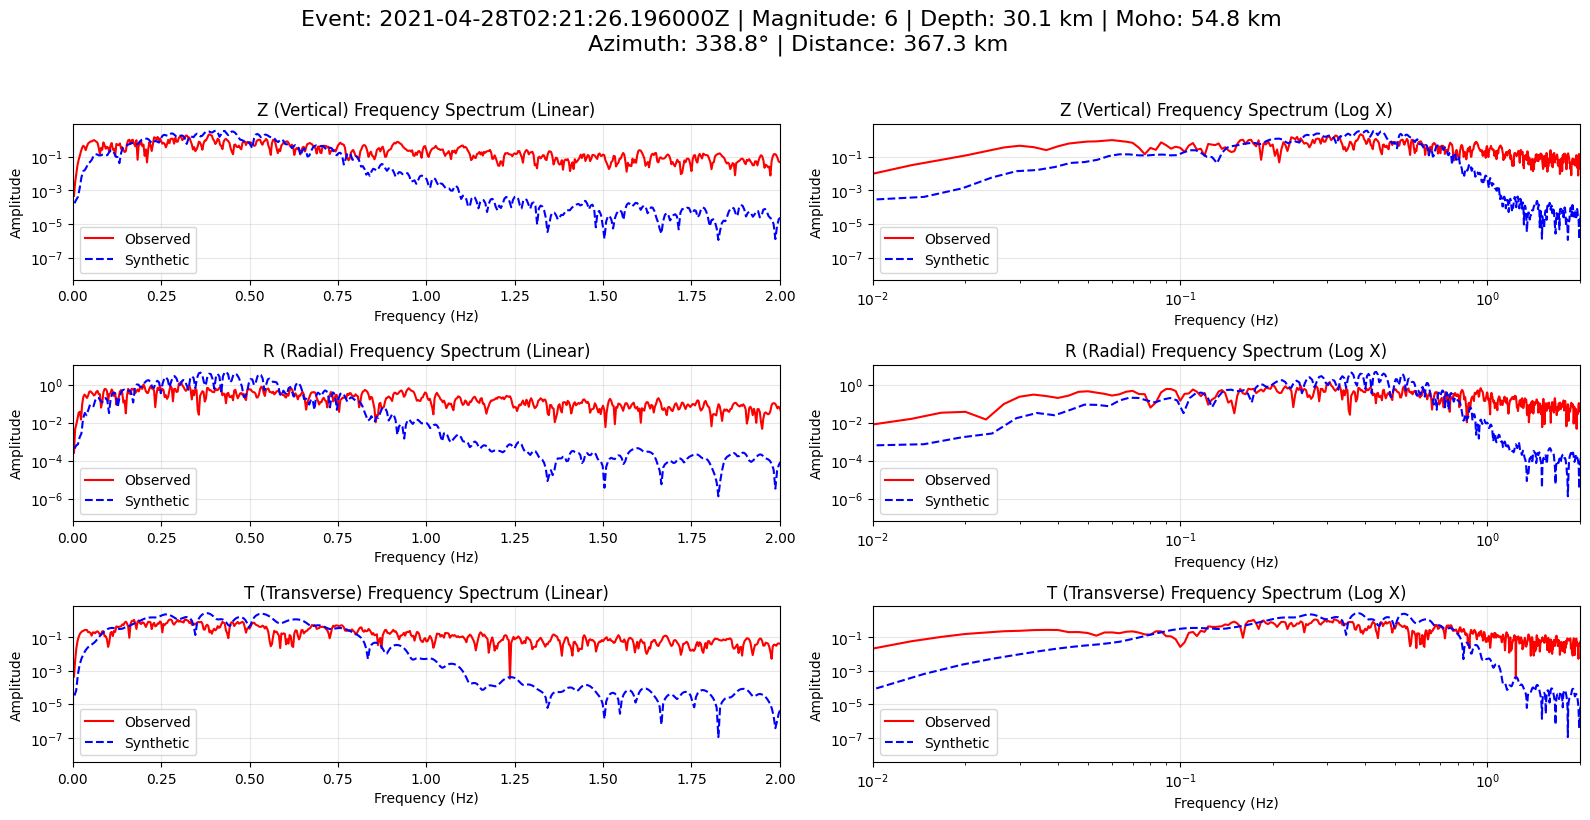

In [23]:
from scipy.fft import fft, fftfreq

fig, axes = plt.subplots(3, 2, figsize=(16, 8))
fig.suptitle(f"Event: {config.event_starttime} | Magnitude: {config.magnitude} | Depth: {config.source_depth} km | Moho: {config.moho_depth} km \n Azimuth: {selected_azimuth:.1f}° | Distance: {selected_distance:.1f} km", fontsize=16, y=1.02)
component_names = ['Z (Vertical)', 'R (Radial)', 'T (Transverse)']

for i, synthetic_component in enumerate(selected_synthetic[0]):
    # Get observed and synthetic data
    observed_component = process_component2(observed_data[i])
    synthetic_data = process_component2(synthetic_component.copy())
    
    # FFT for observed
    n_obs = len(observed_component.data)
    dt_obs = observed_component.stats.delta
    freq_obs = fftfreq(n_obs, dt_obs)
    fft_obs = fft(observed_component.data)
    mag_obs = np.abs(fft_obs)
    mask_obs = freq_obs > 0  # Only positive frequencies

    # FFT for synthetic
    n_syn = len(synthetic_data.data)
    dt_syn = synthetic_data.stats.delta
    freq_syn = fftfreq(n_syn, dt_syn)
    fft_syn = fft(synthetic_data.data)
    mag_syn = np.abs(fft_syn)
    mask_syn = freq_syn > 0  # Only positive frequencies

    # Create frequency masks for normalization band (0.02 to 0.2 Hz)
    norm_mask_obs = (freq_obs >= 0.02) & (freq_obs <= 0.2) & mask_obs
    norm_mask_syn = (freq_syn >= 0.02) & (freq_syn <= 0.2) & mask_syn

    # Normalize based on maximum amplitude in the 0.02-0.2 Hz band
    mag_obs_norm = mag_obs / np.max(mag_obs[norm_mask_obs])
    mag_syn_norm = mag_syn / np.max(mag_syn[norm_mask_syn])

    # Left plot (linear x-axis)
    axes[i, 0].plot(freq_obs[mask_obs], mag_obs_norm[mask_obs], 'r-', label='Observed')
    axes[i, 0].plot(freq_syn[mask_syn], mag_syn_norm[mask_syn], 'b--', label='Synthetic')
    axes[i, 0].set_title(f'{component_names[i]} Frequency Spectrum (Linear)')
    axes[i, 0].set_xlabel('Frequency (Hz)')
    axes[i, 0].set_ylabel('Amplitude')
    axes[i, 0].set_xlim(0, min(2, 0.5/dt_obs, 0.5/dt_syn)) # Show up to 2 Hz or Nyquist (highest frequency that can be represented in signal), whichever is lower
    axes[i, 0].set_yscale('log')
    axes[i, 0].grid(True, alpha=0.3)
    axes[i, 0].legend()

    # Right plot (log x-axis)
    axes[i, 1].semilogx(freq_obs[mask_obs], mag_obs_norm[mask_obs], 'r-', label='Observed')
    axes[i, 1].semilogx(freq_syn[mask_syn], mag_syn_norm[mask_syn], 'b--', label='Synthetic')
    axes[i, 1].set_title(f'{component_names[i]} Frequency Spectrum (Log X)')
    axes[i, 1].set_xlabel('Frequency (Hz)')
    axes[i, 1].set_ylabel('Amplitude')
    axes[i, 1].set_xlim(0.01, min(2, 0.5/dt_obs, 0.5/dt_syn))  # Start at 0.01 Hz for log scale
    axes[i, 1].set_yscale('log')
    axes[i, 1].grid(True, alpha=0.3)
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

## Calculate SnRLg in frequency domain

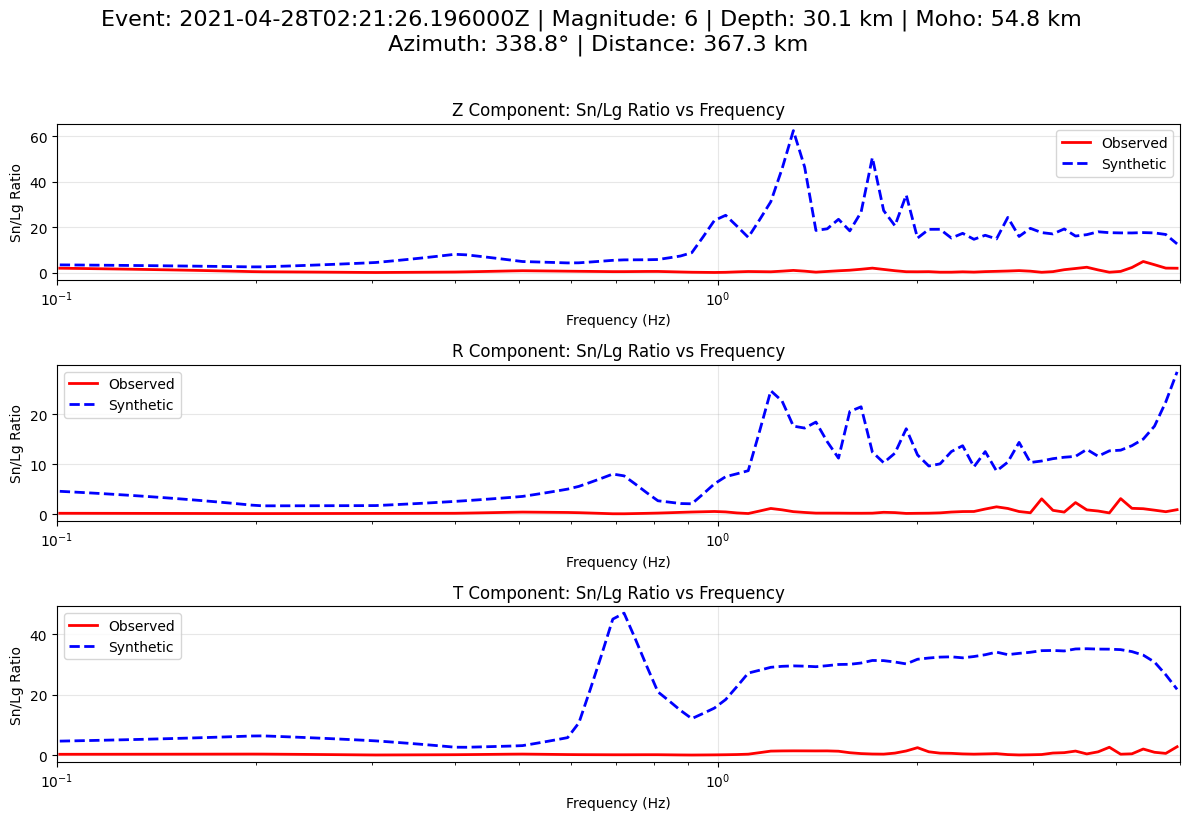

In [24]:
# UNCOMMENT THIS TO RUN THE CODE BELOW
from scipy.fft import fft, fftfreq
import numpy as np 

def calculate_snlg_frequency_ratio(stream, sn_window, lg_window, component_index=0):
    """
    Calculate Sn/Lg ratio in the frequency domain for a given component
    
    Parameters:
    stream: ObsPy Stream with 3 components
    sn_window: (start_time, end_time) in seconds from trace start
    lg_window: (start_time, end_time) in seconds from trace start
    component_index: 0=Z, 1=R, 2=T
    
    Returns:
    freq: frequency array
    sn_spectrum: Sn amplitude spectrum
    lg_spectrum: Lg amplitude spectrum
    snlg_ratio: Sn/Lg ratio at each frequency
    """
    
    # Get the component trace (Z, R, or T) from the stream
    tr = stream[component_index]
    dt = tr.stats.delta 
    
    # Convert time windows from seconds to array indices
    sn_start_idx = int(sn_window[0] / dt)  # Start index for Sn window
    sn_end_idx = int(sn_window[1] / dt)    # End index for Sn window
    lg_start_idx = int(lg_window[0] / dt)  # Start index for Lg window
    lg_end_idx = int(lg_window[1] / dt)    # End index for Lg window
    
    # Extract the time series data for Sn and Lg windows
    sn_data = tr.data[sn_start_idx:sn_end_idx]  # Sn phase data
    lg_data = tr.data[lg_start_idx:lg_end_idx]  # Lg phase data
    
    # Apply Hanning window taper to reduce spectral leakage from sharp edges
    sn_data = sn_data * np.hanning(len(sn_data)) 
    lg_data = lg_data * np.hanning(len(lg_data))
    
    # Compute FFT for Sn window
    n_sn = len(sn_data)  # Number of points in Sn window
    freq_sn = fftfreq(n_sn, dt)  # Create frequency array for Sn (includes negative frequencies)
    fft_sn = fft(sn_data)  # Compute FFT of Sn data
    mag_sn = np.abs(fft_sn)  # Get magnitude (amplitude) spectrum of Sn
    mask_sn = freq_sn > 0  # Create boolean mask for positive frequencies only
    
    # Compute FFT for Lg window
    n_lg = len(lg_data)  # Number of points in Lg window
    freq_lg = fftfreq(n_lg, dt)  # Create frequency array for Lg (includes negative frequencies)
    fft_lg = fft(lg_data)  # Compute FFT of Lg data
    mag_lg = np.abs(fft_lg)  # Get magnitude (amplitude) spectrum of Lg
    mask_lg = freq_lg > 0  # Create boolean mask for positive frequencies only
    
     
    if len(freq_sn[mask_sn]) <= len(freq_lg[mask_lg]):
        # If Sn has fewer frequency points, use Sn frequency grid
        freq = freq_sn[mask_sn]  # Use Sn frequency array
        sn_spectrum = mag_sn[mask_sn]  # Sn spectrum at Sn frequencies
        lg_spectrum = np.interp(freq, freq_lg[mask_lg], mag_lg[mask_lg])  # Interpolate Lg to Sn frequencies
    else:
        # If Lg has fewer frequency points, use Lg frequency grid
        freq = freq_lg[mask_lg]  # Use Lg frequency array
        lg_spectrum = mag_lg[mask_lg]  # Lg spectrum at Lg frequencies
        sn_spectrum = np.interp(freq, freq_sn[mask_sn], mag_sn[mask_sn])  # Interpolate Sn to Lg frequencies
    
    # Calculate Sn/Lg ratio at each frequency (avoid division by zero)
    snlg_ratio = np.where(lg_spectrum > 0, sn_spectrum / lg_spectrum, np.nan)  # Set ratio to NaN where Lg amplitude is zero
    
    return freq, sn_spectrum, lg_spectrum, snlg_ratio  # Return all computed arrays

# Calculate frequency-domain Sn/Lg ratios for observed and synthetic
component_names = ['Z', 'R', 'T']  # Define component names for output

# print("=== Frequency Domain Sn/Lg Analysis ===")  # Print header

# Plot the frequency-domain ratios
fig, axes = plt.subplots(3, 1, figsize=(12, 8))
fig.suptitle(f"Event: {config.event_starttime} | Magnitude: {config.magnitude} | Depth: {config.source_depth} km | Moho: {config.moho_depth} km \n Azimuth: {selected_azimuth:.1f}° | Distance: {selected_distance:.1f} km", fontsize=16, y=1.02)

for i, comp_name in enumerate(component_names):  # Loop through each component for plotting
    # Get Sn and Lg windows (same as above)
    sn_window = snlg_analyzer1.snlg_onepair.sn_window  # Extract Sn time window
    lg_window = snlg_analyzer1.snlg_onepair.lg_window  # Extract Lg time window
    
    # Calculate frequency-domain ratios for observed data
    freq_obs, sn_obs, lg_obs, ratio_obs = calculate_snlg_frequency_ratio(
        observed_data_SnLg, sn_window, lg_window, i  # Pass observed stream, windows, and component index
    )
    
    # Calculate frequency-domain ratios for synthetic data
    freq_syn, sn_syn, lg_syn, ratio_syn = calculate_snlg_frequency_ratio(
        selected_synthetic_SnLg, sn_window, lg_window, i  # Pass synthetic stream, windows, and component index
    )
    
    # Create a common frequency grid for plotting (logarithmically spaced)
    freq_min = max(freq_obs[0], freq_syn[0])  # Find the higher minimum frequency
    freq_max = min(freq_obs[-1], freq_syn[-1])  # Find the lower maximum frequency
    freq_plot = np.logspace(np.log10(freq_min), np.log10(freq_max), 100)  # Create 100 log-spaced frequencies
    # Interpolate both ratio arrays to the common plotting frequency grid
    ratio_obs_plot = np.interp(freq_plot, freq_obs, ratio_obs)  # Interpolate observed ratios
    ratio_syn_plot = np.interp(freq_plot, freq_syn, ratio_syn)  # Interpolate synthetic ratios
    
    # Plot the frequency-domain Sn/Lg ratios
    axes[i].semilogx(freq_plot, ratio_obs_plot, 'r-', label='Observed', linewidth=2)  # Plot observed (red solid line)
    axes[i].semilogx(freq_plot, ratio_syn_plot, 'b--', label='Synthetic', linewidth=2)  # Plot synthetic (blue dashed line)
    axes[i].set_title(f'{comp_name} Component: Sn/Lg Ratio vs Frequency')  # Set subplot title
    axes[i].set_xlabel('Frequency (Hz)')  # Set x-axis label
    axes[i].set_ylabel('Sn/Lg Ratio')  # Set y-axis label
    axes[i].grid(True, alpha=0.3)  # Add grid with transparency
    axes[i].legend()  # Add legend
    axes[i].set_xlim(0.1, 5.0)  # Set x-axis limits (0.1 to 5.0 Hz)

plt.tight_layout()
plt.show()